# Twitter-POS Dataset

Tweet part-of-speech tagging is a natural language processing dataset focusing on tagging words. The dataset is relatively small (1000 training, 327 validation, and 500 testing tweets), which make it suitable for us to study the generalization ability of the trained model.

In this notebook, we test 6 different activation functions, i.e., 'relu', 'prelu', 'elu', 'silu', 'mish', and 'gelu'.

# Initialization



Import packages and mount drive.

In [9]:
import numpy as np
import pickle
import sys
import io
import os

In [10]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Implement helper functions for Tweet-POS dataset. (heavily based on this [repo](https://github.com/hendrycks/GELUs/blob/master/twitter_pos.py))

In [11]:
#
# Begin Twitter Helper Functions
#

def embeddings_to_dict(filename):
    '''
    :param filename: the file name of the word embeddings | file is assumed
    to follow this format: "word[tab]dimension 1[space]dimension 2[space]...[space]dimension 50"
    :return: a dictionary with keys that are words and values that are the embedding of a word
    '''
    with io.open(filename, 'r', encoding='utf-8') as f:
        word_vecs = {}
        for line in f:
            line = line.strip('\n').split()
            word_vecs[line[0]] = np.array([float(s) for s in line[1:]])

    return word_vecs


def data_to_mat(filename, vocab, tag_to_number, window_size=1, start_symbol=u'UUUNKKK',
                one_hot=False, return_labels=True):
    '''
    :param filename: the filename of a training, development, devtest, or test set
    :param vocab: a list of strings, one for each embedding (the keys of a dictionary)
    :param tag_to_number: a dictionary of tags to predict and a numerical encoding of those tags;
    with this, we will predict numbers instead of strings
    :param window_size: the context window size for the left and right; thus we have 2*window_size + 1
    words considered at a time
    :param start_symbol: since the <s> symbol has no embedding given, chose a symbol in the vocab
    to replace <s>. Common choices are u'UUUNKKK' or u'</s>'
    :return: a n x (window_size*2 + 1) matrix containing context windows and the center word
    represented as strings; n is the number of examples. ALSO return a n x |tag_to_number|
    matrix of labels for the n examples with a one-hot (1-of-k) encoding
    '''
    with io.open(filename, 'r', encoding='utf-8') as f:
        x, tweet_words, y = [], [], []
        start = True
        for line in f:
            line = line.strip('\n')

            if len(line) == 0:              # if end of tweet
                tweet_words.extend([u'</s>'] * window_size)

                # ensure tweet words are in vocab; if not, map to "UUUNKKK"

                tweet_words = [w if w in vocab else u'UUUNKKK' for w in tweet_words]

                # from this tweet, add the training tasks to dataset
                # the tags were already added to y
                for i in range(window_size, len(tweet_words) - window_size):
                    x.append(tweet_words[i-window_size:i+window_size+1])

                tweet_words = []
                start = True
                continue

            # if before end
            word, label = line.split('\t')

            if start:
                tweet_words.extend([start_symbol] * window_size)
                start = False

            tweet_words.append(word)

            if return_labels is True:
                if one_hot is True:
                    label_one_hot = len(tag_to_number) * [0]
                    label_one_hot[tag_to_number[label]] += 1

                    y.append(label_one_hot)
                else:
                    y.append(tag_to_number[label])

    return np.array(x), np.array(y)


def word_list_to_embedding(words, embeddings, embedding_dimension=50):
    '''
    :param words: an n x (2*window_size + 1) matrix from data_to_mat
    :param embeddings: an embedding dictionary where keys are strings and values
    are embeddings; the output from embeddings_to_dict
    :param embedding_dimension: the dimension of the values in embeddings; in this
    assignment, embedding_dimension=50
    :return: an n x ((2*window_size + 1)*embedding_dimension) matrix where each entry of the
    words matrix is replaced with its embedding
    '''
    m, n = words.shape
    words = words.reshape((-1))

    return np.array([embeddings[w] for w in words], dtype=np.float32).reshape(m, n*embedding_dimension)


def get_act_fn(nonlinearity_name):
    if nonlinearity_name == 'relu':
        return torch.nn.ReLU()
    elif nonlinearity_name == 'prelu':
        return torch.nn.PReLU()
    elif nonlinearity_name == 'elu':
        return torch.nn.ELU()
    elif nonlinearity_name == 'silu':
        return torch.nn.SiLU()
    elif nonlinearity_name == 'mish':
        return torch.nn.Mish()
    elif nonlinearity_name == 'gelu':
        return torch.nn.GELU()
    else:
        raise NameError("Need 'relu', 'prelu', 'elu', 'silu', 'mish', 'gelu' for nonlinearity_name")


#
# End Twitter Helper Functions
#

Generate input data.

In [12]:
window_size = 1

# note that we encode the tags with numbers for later convenience
tag_to_number = {
    u'N': 0, u'O': 1, u'S': 2, u'^': 3, u'Z': 4, u'L': 5, u'M': 6,
    u'V': 7, u'A': 8, u'R': 9, u'!': 10, u'D': 11, u'P': 12, u'&': 13, u'T': 14,
    u'X': 15, u'Y': 16, u'#': 17, u'@': 18, u'~': 19, u'U': 20, u'E': 21, u'$': 22,
    u',': 23, u'G': 24
}

embeddings = embeddings_to_dict('/content/gdrive/My Drive/GELUs-master/data/Tweets/embeddings-twitter.txt')
vocab = embeddings.keys()

# we replace <s> with </s> since it has no embedding, and </s> is a better embedding than UNK
xt, yt = data_to_mat('/content/gdrive/My Drive/GELUs-master/data/Tweets/tweets-train.txt', vocab, tag_to_number, window_size=window_size,
                     start_symbol=u'</s>')
xdev, ydev = data_to_mat('/content/gdrive/My Drive/GELUs-master/data/Tweets/tweets-dev.txt', vocab, tag_to_number, window_size=window_size,
                         start_symbol=u'</s>')
xdtest, ydtest = data_to_mat('/content/gdrive/My Drive/GELUs-master/data/Tweets/tweets-devtest.txt', vocab, tag_to_number, window_size=window_size,
                             start_symbol=u'</s>')

data = {
    'x_train': xt, 'y_train': yt,
    'x_dev': xdev, 'y_dev': ydev,
    'x_test': xdtest, 'y_test': ydtest
}

In [13]:
print('x_train', data['x_train'], '\n')

print('y_train', data['y_train'], '\n')

x_train [['</s>' 'i' 'predict']
 ['i' 'predict' 'i']
 ['predict' 'i' "won't"]
 ...
 [',' 'my' 'followers']
 ['my' 'followers' 'xd']
 ['followers' 'xd' '</s>']] 

y_train [ 1  7  1 ... 11  0 21] 



# Network Training



Set up training hyperparameters.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset


num_epochs = 50
num_tags = 25
hidden_size = 256
batch_size = 16
embedding_dimension = 50
example_size = (2 * window_size + 1) * embedding_dimension
num_examples = data['y_train'].shape[0]
num_batches = num_examples // batch_size
save_every = num_batches // 5 # save training information 5 times per epoch


nonlinearity_list = ['relu', 'prelu', 'elu', 'silu', 'mish', 'gelu']

Initialize the network. 

According to the paper, we use a simple two-layer network in order to test the generalization ability and convergence speed under different activation functions. Also, we applied dropout for regulization and `Xavire` for network initialization.

In [16]:
class Net(nn.Module):
    def __init__(self, act_fn):
        super().__init__()
        self.fc1 = nn.Linear(example_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_tags)
        self.dropout = nn.Dropout(0.2)
        self.act_fn = act_fn
        
        # initialization
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.act_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.act_fn(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

The network was trained by the following settings:
- Number of Epoch: `50`
- Optimizer: `Adam`
- Loss: `CrossEntropyLoss`
- Learning rate: `[1e-3, 1e-4, 1e-5]`

In [ ]:
learning_rate = 1e-2 # 1e-3 # 1e-4 # 1e-5


for nonlinearity_name in nonlinearity_list:
    
    for n_exp in range(3):


        print('>> %s #%d' % (nonlinearity_name, n_exp))

        history = {
                "lr": learning_rate,
                'train_loss': [], 'val_loss': [], 'test_loss': [],
                'train_acc': [], 'val_acc': [], 'test_acc': []
            }
          
        act_fn = get_act_fn(nonlinearity_name)
        net = Net(act_fn)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
              
        for epoch in range(num_epochs):
            
            print('>>>> Epoch', epoch + 1)            

            # shuffle data every epoch
            indices = np.arange(num_examples)
            np.random.shuffle(indices)
            data['x_train'] = data['x_train'][indices]
            data['y_train'] = data['y_train'][indices]  

            # reset loss            
            running_loss = 0.0
  
            # train
            net.train()

            for i in range(num_batches):
                offset = i * batch_size
                inputs = word_list_to_embedding(data['x_train'][offset:offset + batch_size, :],
                                            embeddings, embedding_dimension)
                labels = data['y_train'][offset:offset + batch_size] 

                inputs = torch.tensor(inputs)
                labels = torch.tensor(labels)
            
                # training
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss

            # training loss
            train_loss = running_loss / len(data['y_train'])
            print('>>>>>> [train_loss] \t %.4f' % train_loss)


            # validation
            net.eval()

            with torch.no_grad():
              inputs = word_list_to_embedding(data['x_train'], embeddings, embedding_dimension)
              labels = data['y_train']

              inputs = torch.tensor(inputs)
              labels = torch.tensor(labels)

              outputs = net(inputs)
              
              # compute loss
              train_loss = criterion(outputs, labels)

              # compute accuracy
              predictions = torch.argmax(outputs, dim=1)
              train_acc = (predictions == labels).float().sum() / len(outputs)

              # print statistics
              print('>>>>>> [train_loss] \t %.4f' % train_loss)
              print('>>>>>> [train_acc] \t %.4f' % train_acc)
              history["train_loss"].append(train_loss)
              history["train_acc"].append(train_acc)

            with torch.no_grad():
              inputs = word_list_to_embedding(data['x_dev'], embeddings, embedding_dimension)
              labels = data['y_dev']

              inputs = torch.tensor(inputs)
              labels = torch.tensor(labels)

              outputs = net(inputs)
              
              # compute loss
              val_loss = criterion(outputs, labels)

              # compute accuracy
              predictions = torch.argmax(outputs, dim=1)
              val_acc = (predictions == labels).float().sum() / len(outputs)

              # print statistics
              print('>>>>>> [val_loss] \t %.4f' % val_loss)
              print('>>>>>> [val_acc] \t %.4f' % val_acc)
              history["val_loss"].append(val_loss)
              history["val_acc"].append(val_acc)

            # testing
            with torch.no_grad():
              inputs = word_list_to_embedding(data['x_test'], embeddings, embedding_dimension)
              labels = data['y_test']

              inputs = torch.tensor(inputs)
              labels = torch.tensor(labels)

              outputs = net(inputs)
              
              # compute loss
              test_loss = criterion(outputs, labels)

              # compute accuracy
              predictions = torch.argmax(outputs, dim=1)
              test_acc = (predictions == labels).float().sum() / len(outputs)

              # print statistics
              print('>>>>>> [test_loss] \t %.4f' % test_loss)
              print('>>>>>> [test_acc] \t %.4f' % test_acc)
              history["test_loss"].append(test_loss)
              history["test_acc"].append(test_acc)

              
        pickle.dump(history, open("/content/gdrive/MyDrive/DL-HW1/twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p", "wb"))

# Discussion: performance and convergence speed

To better understand the relationship between the network convergence and activation functions, we demonstrate the loss value and classification error curve for each epoch.

All results are computed based on the median of three runs.


In [18]:
import matplotlib.pyplot as plt
import numpy as np

num_exp = 3

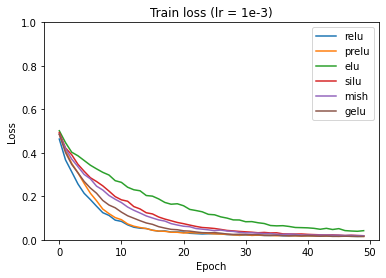

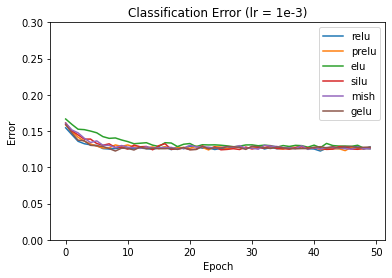

[Classification error (best)]
relu 	 12.248%
prelu 	 12.304%
elu 	 12.570%
silu 	 12.416%
mish 	 12.472%
gelu 	 12.248%


In [19]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-3/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-3)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-3)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-3'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

In the first figures, Relu has the fastest converge speed, while Elu is slightly slower than others according to the loss value.

However, as shown in the second figure, the difference in the dropping speed of the loss curve does not reflect the performance. The final classification error shows no difference under different activation function selections.

We suggest that the activation function does not affect the final performance so much if the trained model is fully converged.

# Discussion: robustness to the learning rate

The former section has shown that the performance does not heavily rely on the activation function under a reasonable learning rate. Yet, the acting of the model under a different set of learning rates still remains unclear.

Accordingly, we test the convergence speed and final performance of each activation function under the following settings:
- Learning rate = [1e-2, 1e-3, 1e-4, 1e-5]


All results are computed based on the median of three runs.

In [23]:
import matplotlib.pyplot as plt
import numpy as np

num_exp = 3
accuracy = {'lr1e-2': {}, 'lr1e-3': {}, 'lr1e-4': {}, 'lr1e-5':{}}

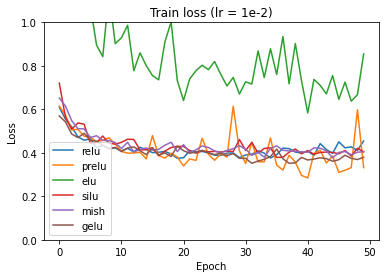

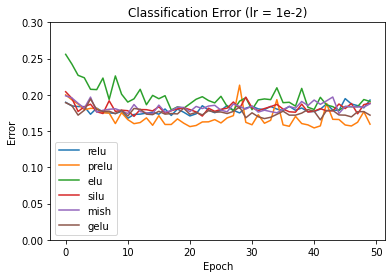

[Classification error (best)]
relu 	 16.765%
prelu 	 15.436%
elu 	 17.827%
silu 	 17.030%
mish 	 17.394%
gelu 	 16.555%


In [24]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-2/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-2)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-2)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-2'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

In the figure, there are several oscillations during the convergence process, which implies the unstable nature of the network training under a fast learning rate.

We observed that Elu function has the highest loss value and classification error. Accordingly, we suggest Elu function is the most sensitive to an unstable condition.

Prelu performs slightly than others, yet it still can only result in sub-optimal performance compared to other settings.

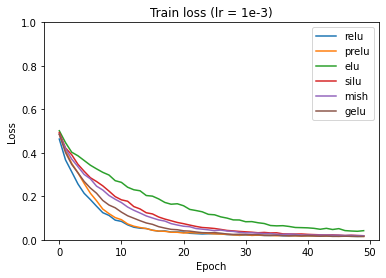

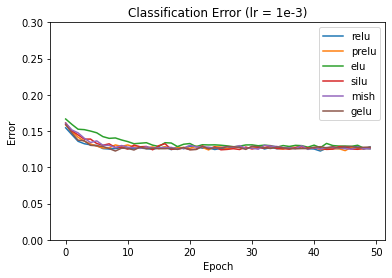

[Classification error (best)]
relu 	 12.248%
prelu 	 12.304%
elu 	 12.570%
silu 	 12.416%
mish 	 12.472%
gelu 	 12.248%


In [25]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-3/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-3)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-3)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-3'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

The result trained under lr=1e-3 had been shown in the previous section.

The performance is similar across all activation function settings.

Thus, we selected them as our best model for Twitter-POS dataset.

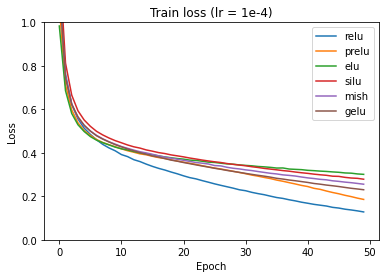

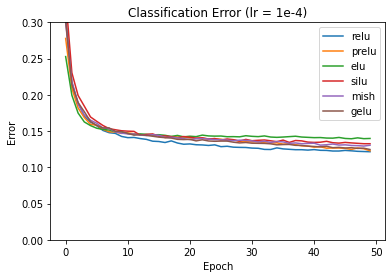

[Classification error (best)]
relu 	 12.150%
prelu 	 12.276%
elu 	 13.940%
silu 	 13.255%
mish 	 12.933%
gelu 	 12.458%


In [26]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-4/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-4)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-4)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-4'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

The curve for `lr=1e-4` is pretty similar to `lr=1e-3`, except the convergence is smoother. On the other hand, the performance is slightly lower but does not show any significant differences.

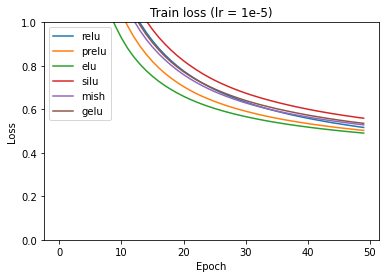

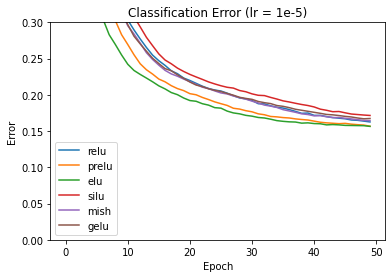

[Classification error (best)]
relu 	 16.261%
prelu 	 15.674%
elu 	 15.646%
silu 	 17.156%
mish 	 16.443%
gelu 	 16.695%


In [27]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-5/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-5)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-5)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-5'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

In the setting of `lr=1e-5`, the loss value and classification error increased compared to the previous settings. We argue that the model does not fully converge due to a slower learning rate.

One interesting finding is that Elu performs the best under such a slow learning rate. We point out that Elu produces a close-to-natural gradient in values closer to zero, which makes it more noise-free than other relu-like functions, especially for small values.

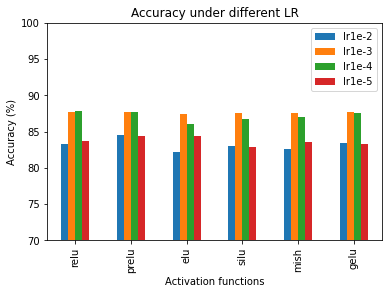

In [28]:
import pandas as pd
pd.DataFrame(accuracy).plot(kind='bar')
plt.xlabel('Activation functions')
plt.ylabel('Accuracy (%)')
plt.ylim(70.0, 100.0)
plt.title("Accuracy under different LR")
plt.show()
plt.close()

Finally, we demonstrate the accuracy of all 6 activation functions under different learning rate settings. In general, `lr1e-3` and `lr1e-4` give us better results compared to the other two settings.

In addition, PRelu shows the best robustness against LR changes as it has the highest performance across different settings.

We attribute it to the adaptive ability of PRelu. While both PRelu and Elu both can propagate negative gradient, only PRelu has the flexibility to adapt the parameters of the rectifiers.

# Discussion: running time

In this section, we compare the training and inference time for the 6 activation functions. Specifically, we run training and inference respectively for 100 epochs and then compute the average spending time for each input sample.

All experiments are conducted on Google Colab.
The hardware specifications are listed as follows:
- CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
- Memory size: 13GB

We did not enable any GPU/TPU acceleration.

In [29]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.140
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.28
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [30]:
!free -h --si

              total        used        free      shared  buff/cache   available
Mem:            13G        667M        9.9G        1.2M        2.7G         12G
Swap:            0B          0B          0B


Avg. training time per samples for relu ms is 125.8390 μs
Avg. training time per samples for prelu ms is 139.7487 μs
Avg. training time per samples for elu ms is 85.6013 μs
Avg. training time per samples for silu ms is 109.5881 μs
Avg. training time per samples for mish ms is 142.5402 μs
Avg. training time per samples for gelu ms is 207.6581 μs


Avg. inference time per samples for relu ms is 4.2859 μs
Avg. inference time per samples for prelu ms is 6.8427 μs
Avg. inference time per samples for elu ms is 4.7391 μs
Avg. inference time per samples for silu ms is 4.4411 μs
Avg. inference time per samples for mish ms is 9.6795 μs
Avg. inference time per samples for gelu ms is 4.9363 μs


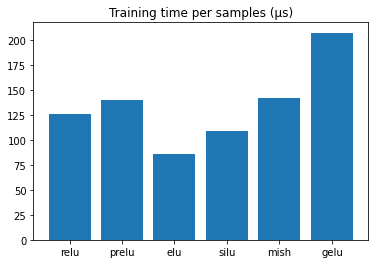

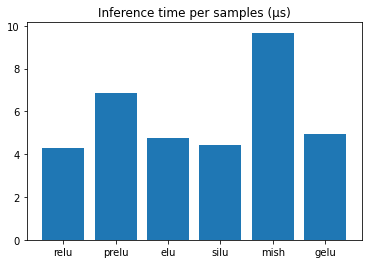

In [33]:
import timeit

learning_rate = 1e-2 # 1e-3 # 1e-4 # 1e-5
testing_epoch = 100
training_times = {}
inference_times = {}

# Training time
for nonlinearity_name in nonlinearity_list:
          
    act_fn = get_act_fn(nonlinearity_name)
    net = Net(act_fn)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Prepare data        
    i = 0
    offset = i * batch_size
    inputs = word_list_to_embedding(data['x_train'][offset:offset + batch_size, :],
                                embeddings, embedding_dimension)
    labels = data['y_train'][offset:offset + batch_size] 

    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
          
    start = timeit.default_timer()

    for epoch in range(testing_epoch):         

        net.train()
        
        # training
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    stop = timeit.default_timer() 

    time = stop - start
    avg_time = time / len(inputs) / testing_epoch
    training_times[nonlinearity_name] = avg_time * 1e6
    print('Avg. training time per samples for %s ms is %.4f μs' % (nonlinearity_name, avg_time * 1e6))


print('\n')


# Inference time
for nonlinearity_name in nonlinearity_list:
          
    act_fn = get_act_fn(nonlinearity_name)
    net = Net(act_fn)

    # Prepare data        
    inputs = word_list_to_embedding(data['x_test'], embeddings, embedding_dimension)
    labels = data['y_test']

    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
          
    start = timeit.default_timer()

    for epoch in range(testing_epoch):
    
        net.eval()

        with torch.no_grad():
          outputs = net(inputs)

    stop = timeit.default_timer()

    time = stop - start
    avg_time = time / len(inputs) / testing_epoch
    inference_times[nonlinearity_name] = avg_time * 1e6
    print('Avg. inference time per samples for %s ms is %.4f μs' % (nonlinearity_name, avg_time * 1e6))



plt.bar(*zip(*training_times.items()))
plt.title("Training time per samples (μs)")
plt.show()
plt.close()

plt.bar(*zip(*inference_times.items()))
plt.title("Inference time per samples (μs)")
plt.show()
plt.close()

As shown in the figure, Gelu significantly spends more time on computing during training. Computing Gelu involves the estimation cumulative distribution function (CDF) of a Gaussian function. There are several ways to improve the approximation of CDF, yet most of them would bring up extra computation costs.


As for inference time, Mish spends the longest time on computing. We attribute it to the complex nature of the Mish function. Specifically, Mish is a combination of multiple functions, i.e., Tanh and Softplus, which significantly increase its complexity.


For the rest function choices, we did not observe notable differences in efficiency between each of them. 



Note that we only have limit access to Colab server and therefore are not able to maintain the necessary consistency for each run. Thus, there might be some unfair environmental changes caused by the hardware-/software-side of Colab.